#**Домашнее задание: многоклассовая классфикация с помощью fine-tuning**

## Stepik: Павел Цветов, User ID: 39555013

## Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)





### Установка зависимостей

In [1]:
!pip install efficientnet_pytorch

In [2]:
import os
import shutil
import glob
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data.dataloader import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import StepLR

import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms

from efficientnet_pytorch import EfficientNet

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from google.colab import drive
from tqdm.autonotebook import tqdm, trange

from pathlib import Path

sns.set(style='whitegrid', font_scale=1.4)

## Вспомогательные функции:
- функции для создания тензоров из изображений, даталоадеров и датасетов в формате PyTorch;
- функции, описывающие процессы обучения, валидации и тестирования модели

In [3]:
def prepare_train_val_test_dirs(source_dir, target_dir, val_size):

    test_dir = os.path.join(target_dir, 'test', 'test')
    shutil.rmtree(test_dir, ignore_errors=True)
    os.makedirs(test_dir, exist_ok=True)

    test_source_dir = os.path.join(source_dir, 'testset', 'testset')
    for filename in glob.glob(os.path.join(test_source_dir, '*.jpg')):
        shutil.copy(filename, test_dir)

    train_dir = os.path.join(target_dir, 'train')
    shutil.rmtree(train_dir, ignore_errors=True)
    os.makedirs(train_dir, exist_ok=True)

    val_dir = os.path.join(target_dir, 'val')
    shutil.rmtree(val_dir, ignore_errors=True)
    os.makedirs(val_dir, exist_ok=True)

    train_source_dir = Path(
        os.path.join(source_dir, 'train', 'simpsons_dataset')
    )
    train_val_files = sorted(list(train_source_dir.rglob('*.jpg')))
    train_val_labels = [path.parent.name for path in train_val_files]
    train_files, val_files = train_test_split(
        train_val_files, test_size=val_size, stratify=train_val_labels
    )

    for files, directory in [(train_files, train_dir), (val_files, val_dir)]:
        for filename in files:
            label_dir = os.path.join(directory, filename.parent.name)
            if not os.path.isdir(label_dir):
                os.makedirs(label_dir, exist_ok=True)
            shutil.copy(filename, label_dir)

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs,
    dataloaders, dataset_sizes):
  
    since = time.time()
    losses = {'train': [], 'val': []}

    best_model_wts = model.state_dict()
    best_score = 0.0

    pbar = trange(num_epochs, desc='epoch:')
    for _ in pbar:

        # каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                # установить модель в режим обучения
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            actual_labels = []
            pred_labels = []

            # итерируемся по батчам
            for data in tqdm(
                    dataloaders[phase], leave=False, desc=f'{phase} iter:'
            ):
                # получаем картинки и метки
                inputs, labels = data
                actual_labels.extend([i.item() for i in labels])

                if USE_GPU:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase == 'train':
                    optimizer.zero_grad()

                # forward pass
                if phase == 'eval':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                pred_labels.extend([i.item() for i in preds])

                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # считаем статистику
                running_loss += loss.item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_score = f1_score(actual_labels, pred_labels, average='micro')

            losses[phase].append(epoch_loss)

            pbar.set_description('{} loss: {:.4f} score: {:.4f}'.format(
                phase, epoch_loss, epoch_score
            ))

            # если получили лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_score > best_score:
                best_score = epoch_score
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best score: {:4f}'.format(best_score))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [5]:
def evaluate(model, dataloader):
  
    model.eval()

    actual_labels = []
    pred_labels = []
    for data in dataloader:
        # получаем картинки и метки
        inputs, labels = data
        actual_labels.extend([i.item() for i in labels])

        # переносим на gpu, если возможно
        if USE_GPU:
            inputs = inputs.cuda()

        # forward pass
        output = model(inputs)
        _, pred = torch.max(output, 1)
        pred_labels.extend([i.item() for i in pred])

    return actual_labels, pred_labels

In [6]:
def predict(model, dataloader):
  
    with torch.no_grad():
        logits = []
        for inputs, _ in dataloader:
            if USE_GPU:
                inputs = inputs.cuda()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    return nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

In [7]:
def accuracy_by_classes(actual_labels, pred_labels, class_names):
  
    all_items = {}
    correct_items = {}
    for actual, pred in zip(actual_labels, pred_labels):
        name = class_names[actual]
        if name in all_items:
            all_items[name] += 1
        else:
            all_items[name] = 1
            correct_items[name] = 0

        if pred == actual:
            correct_items[name] += 1

    data = [
        (name, correct_items[name] / all_items[name], all_items[name])
        for name in all_items.keys()
    ]
    return pd.DataFrame(data, columns=['name', 'accuracy', 'total_images'])

## Балансировка классов при обучении: 
Инициализация веса каждого класса как частота появления изображения этого класса в датасете

In [8]:
def make_weights_for_balanced_classes(images, num_classes):
    count = [0] * num_classes
    for item in images:
        count[item[1]] += 1

    weight_per_class = [0.] * num_classes
    num_all_images = float(sum(count))

    for i in range(num_classes):
        weight_per_class[i] = num_all_images/float(count[i])

    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]

    return weight

In [9]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

## Загрузка данных из Google Drive

In [10]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
!mkdir -p /data/springfield
!mkdir -p /data/models

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d /data/springfield

In [11]:
prepare_train_val_test_dirs(
    source_dir='/data/springfield',
    target_dir='/data',
    val_size=0.25,
)

## Подготовка датасета и аугментация

In [12]:
PATH_TO_DATA = '/data'
USE_GPU = torch.cuda.is_available()
BATCH_SIZE = 32
IMAGE_SIZE = 240

In [13]:
!nvidia-smi

Mon Apr 26 17:52:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Трансформации для train (включая data augmentation) и valid датасетов с нормализацией:

In [14]:
train_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE+20, IMAGE_SIZE+20)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
train_dataset = datasets.ImageFolder(
    root=os.path.join(PATH_TO_DATA, 'train'),
    transform=train_transforms,
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(PATH_TO_DATA, 'val'),
    transform=val_transforms,
)

class_names = train_dataset.classes

In [16]:
weights = make_weights_for_balanced_classes(train_dataset.imgs, len(class_names))
weights = torch.DoubleTensor(weights)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

## **Обучение модели**
## Efficient Net



Движемся дальше. Поговорим об эффективности более подробно. До этого архитектуры сетей, можно сказать, подбирались руками. Так у нас есть ResNet50, а не ResNet54 со свертками 3x3 а не 4x4.

Но если у нас есть достаточно ресурсов, то можно попробовать обучить алгоритм, который будет подбирать правильные параметры для слоев. Для начала нужно определить какие бывают методы для увеличения сети и запустить по ним grid search:

![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)

Затем основываясь на основе этих данны можно получить оптимальную архитектуру длясвоего числа параметров

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

И оказывается, что даже самая маленькая сеть будет показывать лучшие результаты.

![](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

Подробнее [здесь](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).

В качестве базового варианта выберем предобученную модель EfficientNet-B3. Заменим последний слой классификатора на собственный с 42 выходными классами.

In [23]:
model = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [24]:
model._fc

Linear(in_features=1536, out_features=1000, bias=True)

In [20]:
num_features = model._fc.in_features

# заменяем FC layer на собственный линейны классификатор с 42 классами
model._fc = nn.Linear(num_features, len(class_names))

if USE_GPU:
    model = model.cuda()

# Объявляем и инициализируем функцию потерь и оптимизатор AdamW
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# умножаем learning_rate на 0.1 каждые 6 эпох
step_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [21]:
torch.cuda.empty_cache()

In [ ]:
# Обучаем сеть в течение 15 эпох

model, losses = train_model(
    model=model,
    criterion=loss_fn,
    optimizer=optimizer_ft,
    scheduler=step_lr_scheduler,
    num_epochs=15,
    dataloaders={'train': train_loader, 'val': val_loader},
    dataset_sizes={'train': len(train_dataset), 'val': len(val_dataset)},
)

Посмотрим на график loss на обучени и валидации

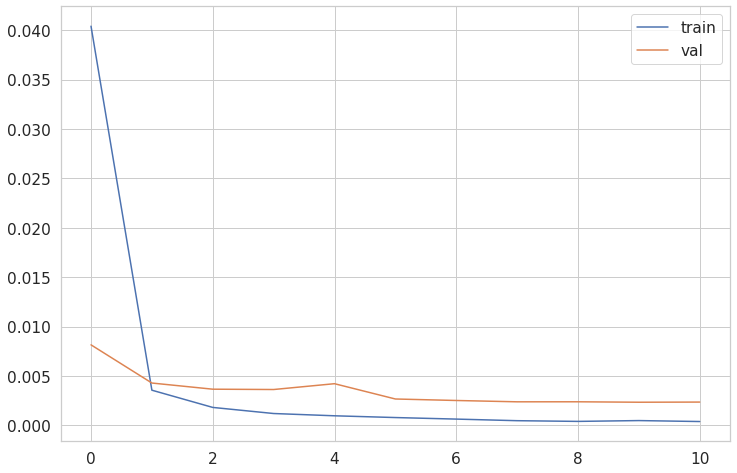

In [27]:
plt.figure(figsize=(12, 8))

plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')

plt.legend()
plt.show()

Сохраняем лучшую модель и производим расчет метрики F1 на валидационном датасете

In [28]:
torch.save(model.state_dict(), 'efficientnet-b3.pth')

In [29]:
actual_labels, pred_labels = evaluate(model, val_loader)

In [30]:
f1_score(actual_labels, pred_labels, average='micro')

0.9831868551776843

## Submission на Kaggle

In [31]:
test_dataset = datasets.ImageFolder(
    root=os.path.join(PATH_TO_DATA, 'test'),
    transform=val_transforms,
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

probs = predict(model, test_loader)
preds = [class_names[i] for i in np.argmax(probs, axis=1)]
test_filenames = [Path(file_path).name for file_path, _ in test_dataset.imgs]

In [32]:
submission = pd.DataFrame({
    'Id': test_filenames,
    'Expected': preds
})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [34]:
submission.to_csv('submission_b3.csv', index=False)